# Railgun Model

Thomas Jagielski and Duncan  Mazza

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import math

## Introduction

Railguns are powerful tools that can be used to launch projectiles at extremely high velocity using electromagnetic forces. While connotations of railguns are typically in the realm of weaponry and military usage, they could also be used to assist in launching satellites into space, propelling plasma, or launching baseballs at very high velocities.

## Questions

1. What is the launch velocity of a projectile (in this case, a baseball) from a railgun with a given current and given specifications of the armature, projectile, rails, etc.?


2. With a target of a given location (in a 2D plane in line with the railgun's rails) and a given launch velocity determined by the railgun model, what angle from the horizontal axis will result in the baseball striking the target? 

In [28]:
num_sweeps = 15
angle_elevation = Params(angle_elevation = pi / 4);

params = Params(mass_proj = 0.145, #kg
                rail_r = 0.01, #m rail radius
                rail_l = 3, #m rail length
                arm_w = 0.9, #m armature width in x axis
                arm_l = 0.01, #m armature length in y axis
                arm_d = 0.02, #m armature depth in z axis
                w = 0.1, #m rail separation
                # mu = 1150, #T  
                mu = 10, # permeability constant of rails 
                rho_cu = 8960, #g/m^3 density of Cu (copper)
                v_init = 0, #m/s
                y_init = 0, #m
                t_end = 1000,
                coef_fric = 0.36, #dimensionless, dynamic friction between copper and mild steel (the surface that the copper armature slides against)
                g = 9.8, #m/s*s
                angle_elevation = angle_elevation.angle_elevation, #radians from horizontal; being swept
                cd = 2, # approximate drag coefficient of a rectangular box 
                rho_air = 1.225, # kg/m^3 density of air
                current = 1000 # amperes
               )
;

''

### Force Diagram
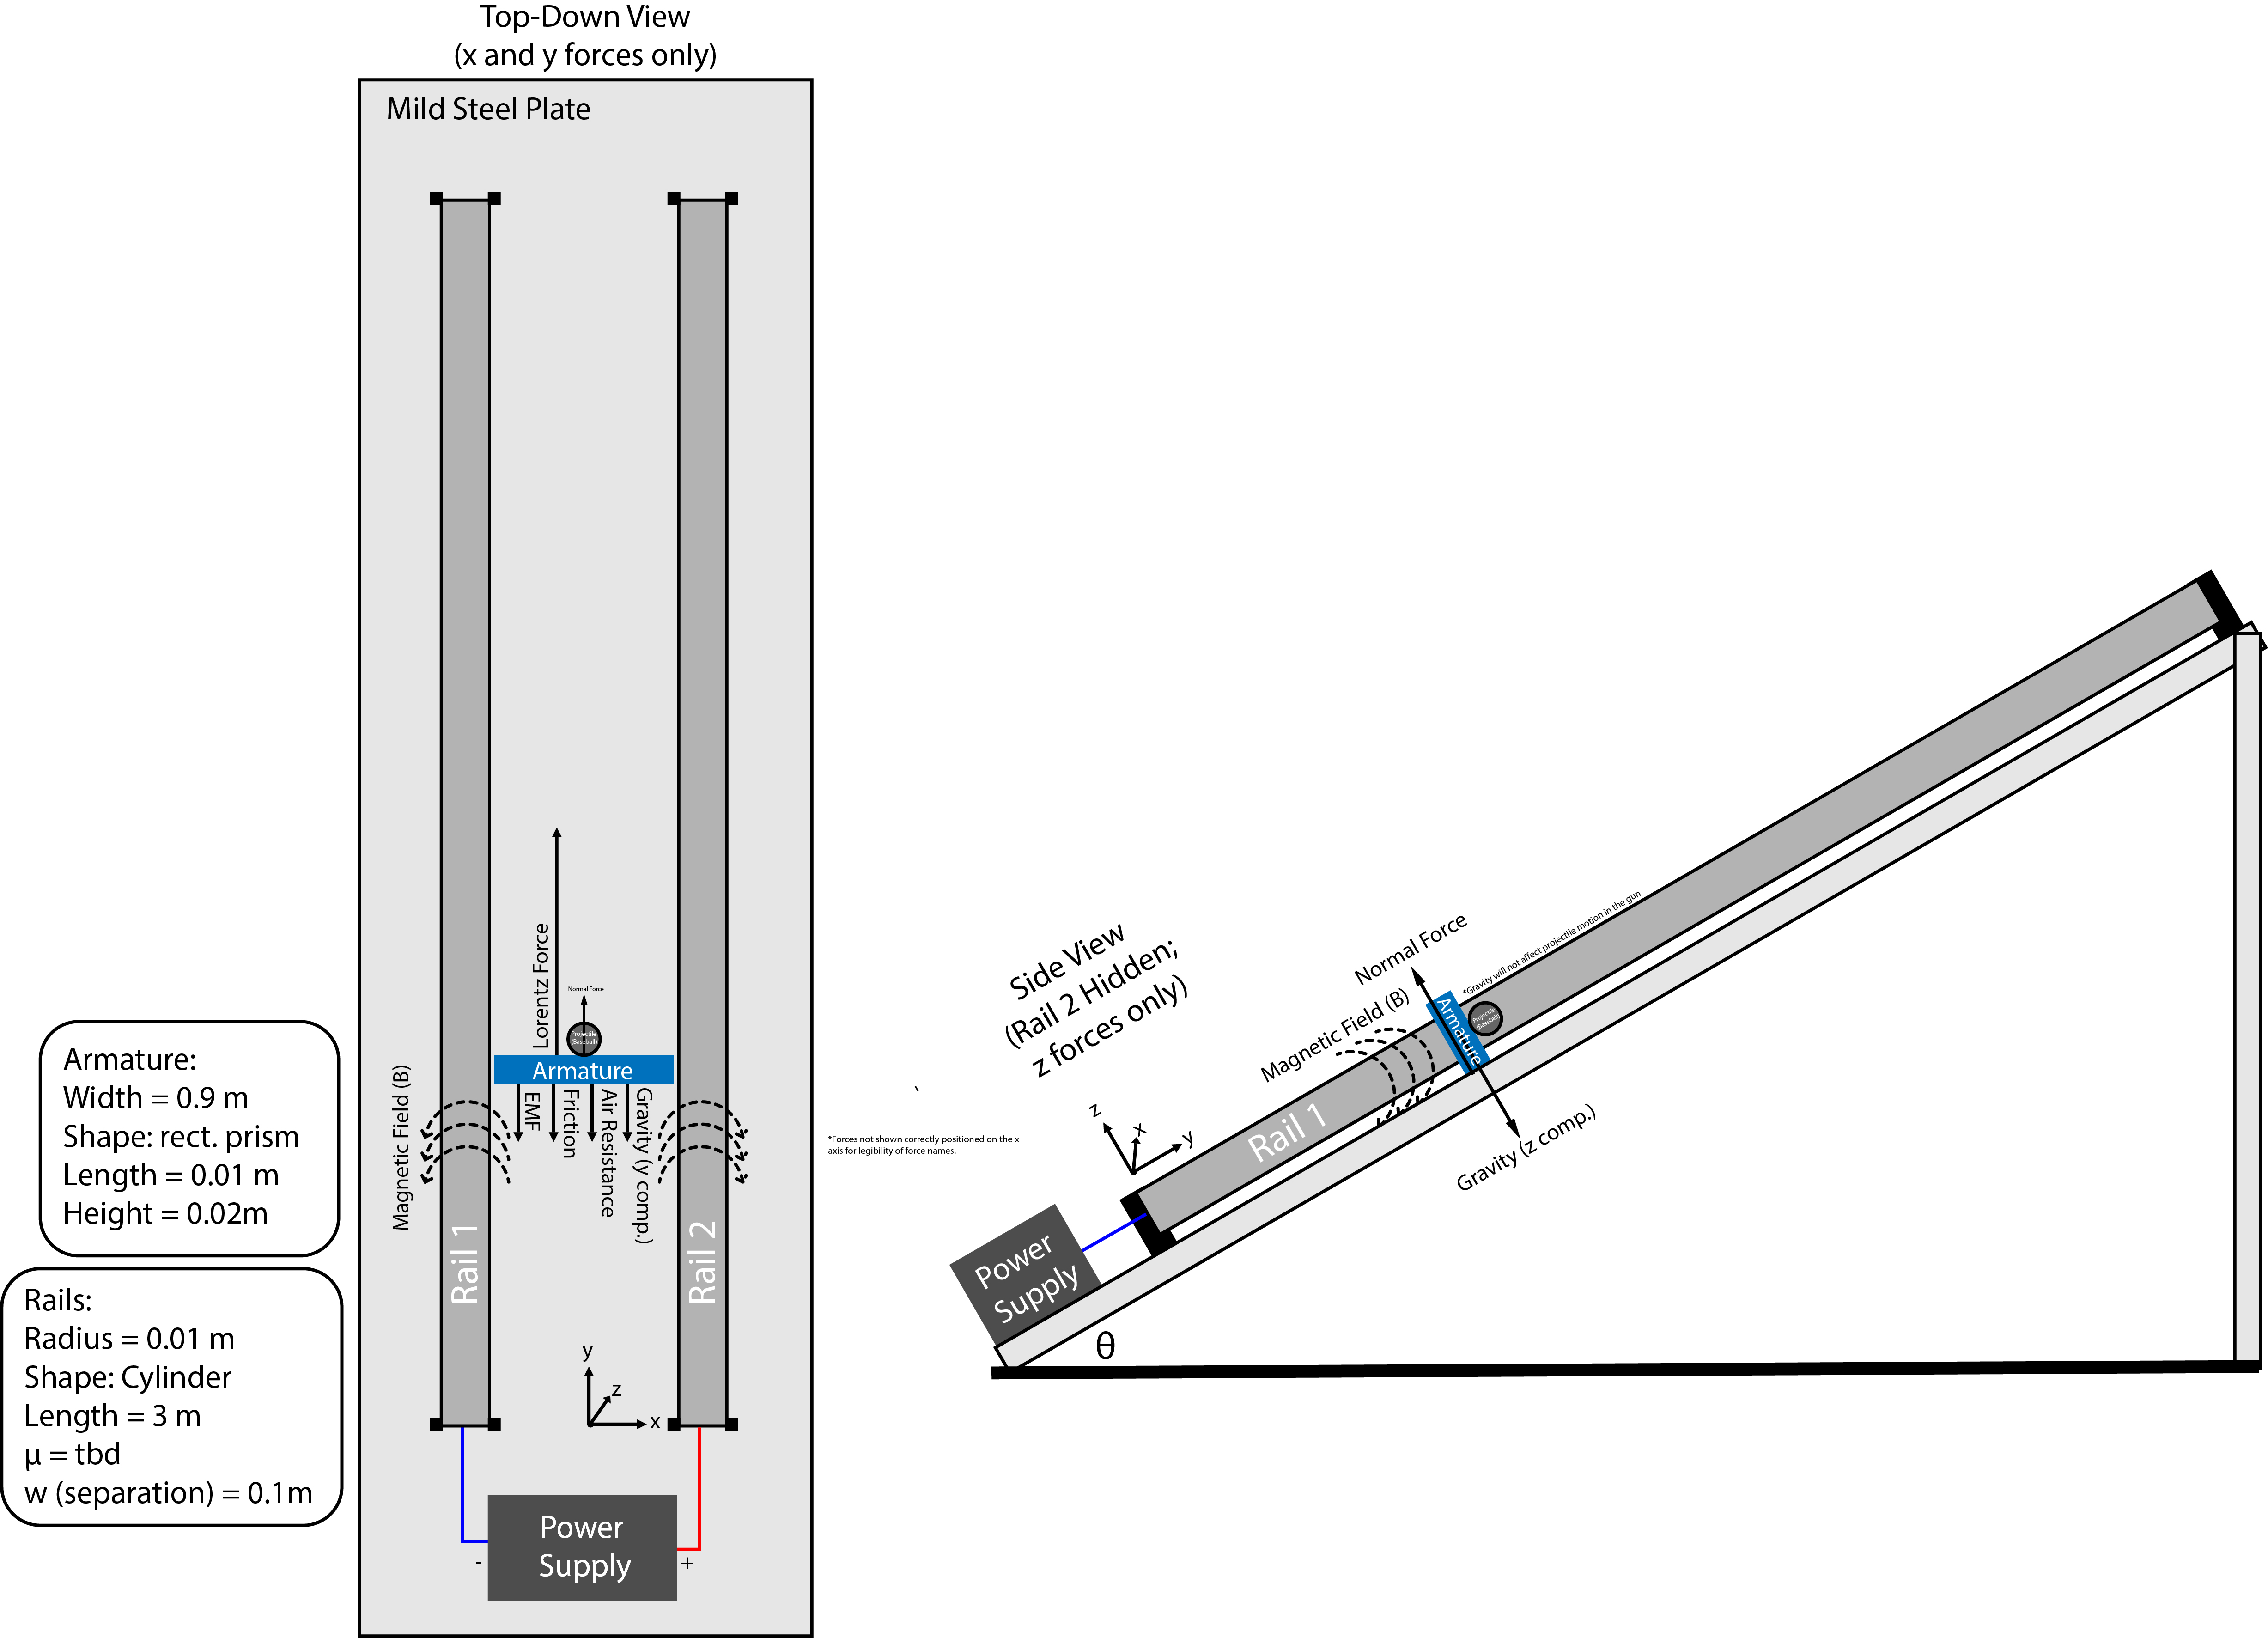

### Equations used for railgun

$$F_{lorentz} = \frac{\mu_0 i^2}{2 \pi} * \ln \frac{R + w}{R}$$

$$F_{EMF} = -B \gamma w \textrm {, where:}$$

$$B = \frac{\mu_0 i}{2 \pi w} * \ln \frac{R + w}{R}$$

$$F_{friction} = \mu_d F_{g_y} m_{arm} \textrm {, where:} $$

$$ F_{g_y} = F_g cos(\theta)$$

Variables are labeled in the parameter objects with their units and what they represent, except for `rail_r` which is expressed as $R$. Derivation for equations can be found in the paper (linked at the bottom) on railgun physics. 

### Assumptions and Constraints

To use the aforementioned equations, the following assumptions/constraints must be considered: 

- Constant lorentz force, which is dependent on:    

    - Constant current
    
    - The rails are made of iron (magnetic)
    
    - Rails are separated enough (by length w) relative to their diameter
    
    - Rails are long enough relative to their separation (w) so they can be treated by the equations as rails of infinite length.
    
    - Armature is made of copper (conductive)
    
    - Rails are cylindrical and wire-like (small diameter)
    
    - Uniform current density
    
    - Thin armature
    
    - Constant mu
    
    - No energy loss to magnetization
    
    - No energy lost to eddy currents
    
- Coefficient of drag for armature is constant and is 2

- Flow speed around armature equals the armatures velocity

These assumptions and constraints are incorporated into our model, and can be 

In [4]:
def make_system(params):
    """Make a system object.
    
    params: parameter object
    
    returns: System object
    """

    unpack(params)
    
    mass_arm = (arm_w * arm_l * arm_d) * rho_cu
    
    # Magnetic force in railgun on armature
    lorentz_force = ((mu * current**2)/(2 * np.pi)) * (math.log((rail_r + w) / rail_r))
    
    # Magnetic field strength
    B = ((mu * current)/(2 * np.pi * w)) * (math.log((rail_r + w) / rail_r))
    
    # Friction force on armature
    arm_friction = coef_fric * (g * mass_arm * math.cos(angle_elevation))
    
    # Force of gravity in y direction
    gravity_y_direc = g * mass_arm * math.sin(angle_elevation)
    
    # Cross-sectional area of armature
    front_area = arm_w * arm_d #m^2 frontal areaa of the armature 
    
    init = State(v=v_init, y=y_init)
    
    return System(params, lorentz_force=lorentz_force, mass_arm = mass_arm, B = B, arm_friction = arm_friction, 
                  gravity_y_direc = gravity_y_direc, front_area = front_area, init=init)

In [5]:
system = make_system(params);

In [6]:
def slope_func(state, t, system):
    """Define differential equations for velocity and acceleration
    
    state: v = velocity, y = position in railgun
    t: time
    system: System object
    
    returns: acceleration and velocity
    """
    
    unpack(system)
    v, y = state
    
    # Electromagnetic force
    emf = B * v * w 
    
    # The u of the drag force equation will be set equal to velocity (v)
    air_resistance = 0.5 * rho_air * (v**2) * cd * front_area
    
    # Acceleration of the armature and projectile
    dvdt = (lorentz_force - emf - arm_friction - gravity_y_direc - air_resistance) / (mass_proj + mass_arm)
    
    # Velocity of armature and projectile
    dydt = v    

    return dvdt, dydt

In [7]:
slope_func(system.init, 0, system)

(2171096.6306084436, 0.0)

In [8]:
def event_func(state, t, system):
    """Event function to stop the simulation when the armature reaches the end of the rails
    
    state: v = velocity, y = position in railgun
    t: time
    system: System object
    
    returns: the difference between armature position and length of rails
    """
    
    v, y = state
    return system.rail_l - y

In [9]:
results, details = run_ode_solver(system, slope_func, events = event_func, max_step=0.00001)
details.message

'A termination event occurred.'

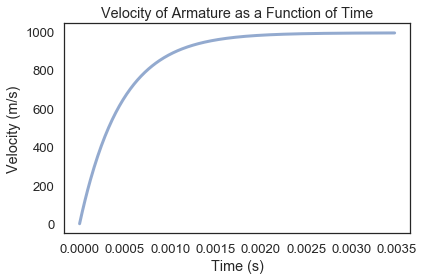

In [10]:
plot(results.v)

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)',
         title='Velocity of Armature as a Function of Time',
         legend=False)

### Projectile Motion 

Assumptions:
- The projectile is a baseball and follows the drag coefficient curve given by `data/baseball_drag.csv`
- No wind in any direction
- No angular velocity of the baseball

In [11]:
params_proj = Params(x = 0, #m 
                     g = 9.8, #m/s^2
                     mass = 145e-3, #kg mass of projectile
                     diameter = 73e-3, #m diameter of projectile
                     rho = 1.2, #kg/m^3 density of air
                     C_d = 0.33, #cooefficient of drag
                     angle = params.angle_elevation, #radians
                     velocity = get_last_value(results.v), #m / s
                     t_end = 200, #s
                     target_x = 320, #m
                     target_y = 0, #m
                     target_radius = 0.5 #m
                     )
;

''

In [12]:
def make_system_proj(params, params1):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
    params1: Params object from railgun simulation
               
    returns: System object
    """
    unpack(params)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(params.angle, velocity)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # define y
    y = math.sin(params.angle) * system.rail_l #m
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    return System(params, init=init, area=area, y=y)

In [13]:
system_proj = make_system_proj(params_proj, params);

In [14]:
m = UNITS.meter
s = UNITS.second

baseball_drag = pd.read_csv('data/baseball_drag.csv')
baseball_drag.index = Quantity(baseball_drag['Velocity in mph'].values, UNITS.mph).to(m/s)
baseball_drag;

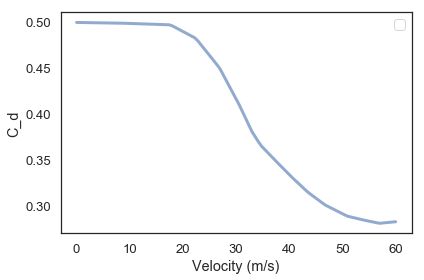

In [15]:
drag_interp = interpolate(baseball_drag['Drag coefficient'])
vs = linspace(0, 60, 101)
cds = drag_interp(vs)
plot(vs, cds)
decorate(xlabel = 'Velocity (m/s)', ylabel = 'C_d')

In [16]:
def drag_force(v, system):
    """finds drag force in the opposing direction to velocity
    
    v: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    
    unpack(system)
    C_d = drag_interp(v.mag)
    mag = -rho * v.mag ** 2 * C_d * area / 2
    direction = v.hat()
    f_drag = direction * mag
    return f_drag

In [17]:
def slope_func_proj(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    v = Vector(vx, vy)    
    a_drag = drag_force(v, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [18]:
slope_func_proj(system_proj.init, 0, system_proj)

(702.721098455984,
 702.721098455984,
 <Quantity(-9628.802796352897, 'dimensionless')>,
 <Quantity(-9638.602796352896, 'dimensionless')>)

In [19]:
def event_func_proj(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y

In [20]:
event_func_proj(system_proj.init, 0, system_proj)

2.121320343559643

In [21]:
system_proj = System(system_proj, drag_interp = drag_interp)
results_proj, details_proj = run_ode_solver(system_proj, slope_func_proj, 
                                            events = event_func_proj, max_step=0.05)
details_proj.message

'A termination event occurred.'

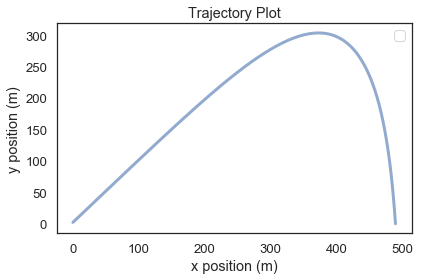

In [22]:
plot(results_proj.x, results_proj.y)

decorate(title='Trajectory Plot', 
         xlabel='x position (m)',
         ylabel='y position (m)')

In [23]:
def simulation(angle_elevation):
    """Run through all functions in simualtion
    
    angle_elevation: angle between the railgun and ground
    
    returns: Position vector of projectile
    """
    
    params_new = Params(params, angle_elevation = angle_elevation)
    system = make_system(params_new)
    results_sim, details_sim = run_ode_solver(system, slope_func, events = event_func, max_step = 0.00001)
  
    params_proj_new = Params(params_proj, angle = params_new.angle_elevation, velocity = get_last_value(results_sim.v))
    system_proj = make_system_proj(params_proj_new, params_new)
    results_proj, details_proj = run_ode_solver(system_proj, slope_func_proj, 
                                            events = event_func_proj, max_step=0.1)
    x = results_proj.x
    y = results_proj.y
    
    xy = Vector(x, y)
    
    return xy

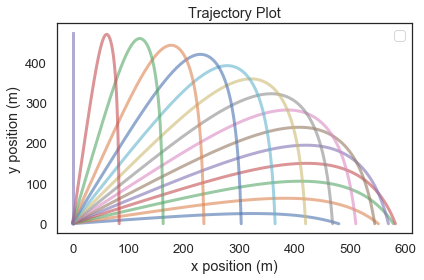

In [24]:
# Sweep angle_elevation
for i in range(0, num_sweeps): 
    angle_linspace = linspace(0.1, pi/2, num_sweeps)
    params.angle_elevation = angle_linspace[i]
    xy = simulation(params.angle_elevation)
    plot(xy.x, xy.y)

decorate(title='Trajectory Plot', 
         xlabel='x position (m)',
         ylabel='y position (m)',
         )

In [25]:
# Assuming that the projectile is on the ground (y = 0):
def simulation_hitting_target(angle_elevation):
    """Run through all functions in simualtion
    
    angle_elevation: angle between the railgun and ground
    
    returns: difference between distance of projectile and target distance
    """
    
    params_new = Params(params, angle_elevation = angle_elevation)
    system = make_system(params_new)
    results_sim, details_sim = run_ode_solver(system, slope_func, events = event_func, max_step = 0.00001)
  
    params_proj_new = Params(params_proj, angle = params_new.angle_elevation, velocity = get_last_value(results_sim.v))
    system_proj = make_system_proj(params_proj_new, params_new)
    results_proj, details_proj = run_ode_solver(system_proj, slope_func_proj, 
                                            events = event_func_proj, max_step=0.1)
    return get_last_value(results_proj.x) - params_proj.target_x

In [26]:
solution = fsolve(simulation_hitting_target, x0 = 1.05);

In [27]:
print('The angle from horizontal that will cause the projectile to hit the target is {} radians.'.format(solution[0]))

The angle from horizontal that will cause the projectile to hit the target is 1.1232657102202284 radians.


### Sources

- Source for coeff fric: http://www.engineershandbook.com/Tables/frictioncoefficients.htm

- Source for drag coeff: https://www.engineeringtoolbox.com/drag-coefficient-d_627.html

- Source for railgun physics: http://citeseerx.ist.psu.edu/viewdoc/download?rep=rep1&type=pdf&doi=10.1.1.205.7739

- Source for air density: https://www.engineersedge.com/calculators/air-density.htm
